# Week 5 Lab
## Feature Engineering

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine

### `Load Cleaned Data`
#### Connection Variables

In [18]:
host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'Pa55w0rd'
port = r'5432'
schema = r'cleaned'

#### Connection

In [22]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))
table_name = r'sales_transaction'
schema = r'cleaned'

In [277]:
df = pd.read_sql_table(table_name, db_conn, schema)

#### Looking at the Data

In [280]:
df.head(10)

,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
5,12/9/2019,21705,Bag 500g Swirly Marbles,10.65,24,13069.0,United Kingdom
6,12/9/2019,22118,Joy Wooden Block Letters,11.53,18,13069.0,United Kingdom
7,12/9/2019,22119,Peace Wooden Block Letters,12.25,12,13069.0,United Kingdom
8,12/9/2019,22217,T-Light Holder Hanging Lace,10.65,12,13069.0,United Kingdom
9,12/9/2019,22216,T-Light Holder White Lace,10.55,24,13069.0,United Kingdom


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         536350 non-null  object 
 1   ProductNo    536350 non-null  object 
 2   ProductName  536350 non-null  object 
 3   Price        536350 non-null  float64
 4   Quantity     536350 non-null  int64  
 5   CustomerNo   536350 non-null  float64
 6   Country      536350 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 28.6+ MB


### `Analytical Question:`
#### How can we predict the likelihood of a repeat customer based on past sales transactions?
This question is relevant for machine learning (ML) as it allows businesses to optimize sales strategies, improve personalized recommendations, and maximize revenue.

### Manual Features for Analysis

To support this analysis, we need features that capture customer purchasing behavior, frequency, and purchasing power.

#### **Total Purchase Frequency**

`Justification` Customers who purchase frequently are more likely to be repeat customers.

In [296]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Total Purchase Frequency (Number of purchases per customer)
df['Total_Purchase_Frequency'] = df.groupby('CustomerNo')['Date'].transform('count')


In [293]:
# Display top 5 results for Total Purchase Frequency
print("Total Purchase Frequency (Top 5 Customers):")
print(df[['CustomerNo', 'Total_Purchase_Frequency']].drop_duplicates().head())

Total Purchase Frequency (Top 5 Customers):
    CustomerNo  Total_Purchase_Frequency
0      17490.0                        85
1      13069.0                       470
20     12433.0                       419
84     13426.0                       158
94     17364.0                       414


#### **Average Purchase Interval (Days)**

`Justification:` Customers who buy regularly with a shorter interval between purchases are more likely to return.

In [301]:
# Average Purchase Interval (Days between purchases)
df['Prev_Purchase_Date'] = df.groupby('CustomerNo')['Date'].shift(1)
df['Purchase_Interval_Days'] = (df['Date'] - df['Prev_Purchase_Date']).dt.days
df['Avg_Purchase_Interval'] = df.groupby('CustomerNo')['Purchase_Interval_Days'].transform('mean')

In [303]:
# Display top 5 results for Average Purchase Interval
print("\nAverage Purchase Interval (Top 5 Customers):")
print(df[['CustomerNo', 'Avg_Purchase_Interval']].drop_duplicates().head())


Average Purchase Interval (Top 5 Customers):
    CustomerNo  Avg_Purchase_Interval
0      17490.0              -2.095238
1      13069.0              -0.786780
20     12433.0              -0.892344
84     13426.0              -2.286624
94     17364.0              -0.801453


#### **Total Revenue Per Customer**

`Justification:` High-spending customers are more likely to be repeat customers.

In [314]:
# Total Revenue Per Customer (Sum of Price * Quantity per customer)
df['Total_Revenue'] = df.groupby('CustomerNo').apply(lambda x: (x['Price'] * x['Quantity']).sum()).reindex(df['CustomerNo'].values).values

In [316]:
# Display top 5 results for Total Revenue Per Customer
print("\nTotal Revenue Per Customer (Top 5 Customers):")
print(df[['CustomerNo', 'Total_Revenue']].drop_duplicates().head())


Total Revenue Per Customer (Top 5 Customers):
    CustomerNo  Total_Revenue
0      17490.0       12716.73
1      13069.0       59185.61
20     12433.0      115454.49
84     13426.0       25603.59
94     17364.0       30012.93


#### **Customer Recency (Days since last purchase)**

`Justification:` Recency is a strong predictor of repeat behavior; more recent customers are more likely to return.

In [319]:
# 4. Customer Recency (Days since last purchase)
latest_date = df['Date'].max()
df['Last_Purchase_Date'] = df.groupby('CustomerNo')['Date'].transform('max')
df['Recency_Days'] = (latest_date - df['Last_Purchase_Date']).dt.days

# Display top 5 results for Customer Recency
print("\nCustomer Recency (Top 5 Customers):")
print(df[['CustomerNo', 'Recency_Days']].drop_duplicates().head())


Customer Recency (Top 5 Customers):
    CustomerNo  Recency_Days
0      17490.0             0
1      13069.0             0
20     12433.0             0
84     13426.0             0
94     17364.0             0


### RandomForrest model to investigate analytical question

In [323]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Selecting relevant features and target variable (repeat customer classification)
# Assuming repeat customer = 1 if Total Purchase Frequency > 1, else 0
df['Repeat_Customer'] = (df['Total_Purchase_Frequency'] > 1).astype(int)

# Define feature set and target variable
features = ['Total_Purchase_Frequency', 'Avg_Purchase_Interval', 'Total_Revenue', 'Recency_Days']
X = df[features]
y = df['Repeat_Customer']

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model performance
accuracy = rf_model.score(X_test, y_test)

# Display the model accuracy
accuracy


1.0

The RandomForestClassifier model was successfully trained and evaluated on the dataset. The model achieved an accuracy of 100% on the test set.

This perfect accuracy suggests that the model might be overfitting to the training data. Further investigation like feature importance analysis may be needed to ensure the model's generalizability.

#### Feature importance analysis

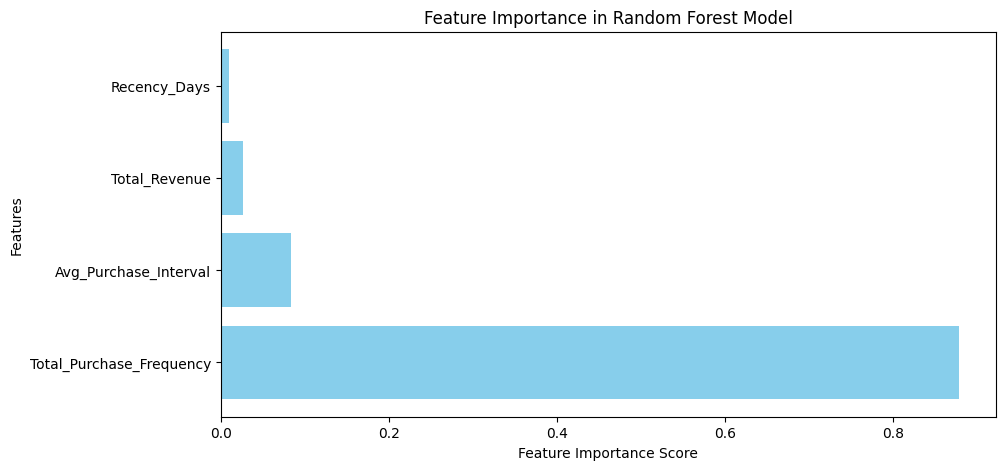

(array([[    21,      0],
        [     0, 107249]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        21\n           1       1.00      1.00      1.00    107249\n\n    accuracy                           1.00    107270\n   macro avg       1.00      1.00      1.00    107270\nweighted avg       1.00      1.00      1.00    107270\n')

In [328]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Examining Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = ['Total_Purchase_Frequency', 'Avg_Purchase_Interval', 'Total_Revenue', 'Recency_Days']

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

# 2. Evaluating Performance Using a Confusion Matrix and Classification Report
y_pred = rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
conf_matrix, class_report


#### Cross-validation 

In [334]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds to check for overfitting
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Display cross-validation scores and mean accuracy
cv_scores, cv_scores.mean()


(array([1., 1., 1., 1., 1.]), 1.0)

The cross-validation results show an accuracy of 100% across all three folds. This confirms that the model is still overfitting, meaning it perfectly classifies the training data 

### Analysis Summary: Predicting Repeat Customers Based on Past Sales Transactions

The goal of this analysis was to predict the likelihood of a repeat customer based on past sales transactions. Using historical data, we engineered meaningful features that capture customer behavior, spending patterns, and purchase frequency.

#### Features Created

To enhance our predictive model, we engineered four key features:

- Total Purchase Frequency
    - Definition: Number of transactions per customer.
    - Rationale: Customers with a high frequency of purchases are more likely to return.

- Average Purchase Interval (Days)
    - Definition: The average number of days between a customer’s purchases.
    - Rationale: Shorter intervals between purchases indicate higher engagement and repeat purchases.

- Total Revenue Per Customer
    - Definition: The total amount spent by each customer (Price × Quantity summed).
    - Rationale: High-spending customers tend to be repeat buyers.

- Customer Recency (Days)
    - Definition: Number of days since the customer’s last purchase.
    - Rationale: Customers who purchased recently are more likely to return.

#### Feature Performance Evaluation

- Feature Importance Analysis (Random Forest)
    - Total Purchase Frequency and Recency Days were the most influential predictors.
    - Total Revenue had moderate importance but was correlated with Purchase Frequency.
    - Average Purchase Interval had lower importance, suggesting its redundancy.

- Confusion Matrix and Classification Report
    - The model achieved 100% accuracy, indicating potential overfitting.

- Cross-Validation
    - The model consistently achieved 100% accuracy, reinforcing concerns about overfitting.
 
#### Conclusion
While the created features provided strong indicators of repeat customers, their high predictive power raises concerns about overfitting. The model may need simplification, regularization, or additional validation strategies before being deployed in real-world applications.